# **Trabajo práctico 1, IA explicable**
Juan Eizaguerri

Daniel Hernández


IMPORTANTE: Este notebook requiere tener en la carpeta montada de Google Colab un directorio /data que contenga los ficheros train.csv y validation.csv proporcionados como material de la práctica.

In [ ]:
#!pip install interpret six graphviz pydotplus

In [17]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image

from interpret import show
from interpret.data import ClassHistogram
from interpret.glassbox import ClassificationTree
from interpret import show
from matplotlib import pyplot as plt
from sklearn.tree import plot_tree
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text
from sklearn.tree import _tree
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score
from sklearn.metrics import roc_curve

## Carga y análisis de datos

In [2]:
train_csv = pd.read_csv("data/train.csv")
validation_csv = pd.read_csv("data/validation.csv")
test_csv = pd.read_csv("data/test.csv")

In [3]:
num_filas_train = train_csv.shape[0]
num_filas_validation = validation_csv.shape[0]
num_filas_test = test_csv.shape[0]

print(f"Número de filas en train_csv: {num_filas_train}")
print(f"Número de filas en validation_csv: {num_filas_validation}")
print(f"Número de filas en test_csv: {num_filas_test}")

num_good_train = train_csv[train_csv['RiskPerformance'] == 'Good'].shape[0]
num_bad_train = train_csv[train_csv['RiskPerformance'] == 'Bad'].shape[0]

num_good_validation = validation_csv[validation_csv['RiskPerformance'] == 'Good'].shape[0]
num_bad_validation = validation_csv[validation_csv['RiskPerformance'] == 'Bad'].shape[0]

num_good_test = test_csv[test_csv['RiskPerformance'] == 'Good'].shape[0]
num_bad_test = test_csv[test_csv['RiskPerformance'] == 'Bad'].shape[0]

print(f"Cantidad de 'Good' en train_csv: {num_good_train}")
print(f"Cantidad de 'Bad' en train_csv: {num_bad_train}")
print(f"Cantidad de 'Good' en validation_csv: {num_good_validation}")
print(f"Cantidad de 'Bad' en validation_csv: {num_bad_validation}")
print(f"Cantidad de 'Good' en test_csv: {num_good_test}")
print(f"Cantidad de 'Bad' en test_csv: {num_bad_test}")

Número de filas en train_csv: 6459
Número de filas en validation_csv: 2000
Número de filas en test_csv: 1888
Cantidad de 'Good' en train_csv: 3109
Cantidad de 'Bad' en train_csv: 3350
Cantidad de 'Good' en validation_csv: 967
Cantidad de 'Bad' en validation_csv: 1033
Cantidad de 'Good' en test_csv: 873
Cantidad de 'Bad' en test_csv: 1015


In [4]:
train_csv

,RiskPerformance,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever2DerogPubRec,NumTrades90Ever2DerogPubRec,PercentTradesNeverDelq,MSinceMostRecentDelq,...,PercentInstallTrades,MSinceMostRecentInqexcl7days,NumInqLast6M,NumInqLast6Mexcl7days,NetFractionRevolvingBurden,NetFractionInstallBurden,NumRevolvingTradesWBalance,NumInstallTradesWBalance,NumBank2NatlTradesWHighUtilization,PercentTradesWBalance
0,Bad,-9,-9,-9,-9,-9,-9,-9,-9,-9,...,-9,-9,-9,-9,-9,-9,-9,-9,-9,-9
1,Bad,65,176,1,19,18,0,0,100,-7,...,10,-7,4,4,38,100,8,2,2,59
2,Good,-9,-9,-9,-9,-9,-9,-9,-9,-9,...,-9,-9,-9,-9,-9,-9,-9,-9,-9,-9
3,Good,-9,-9,-9,-9,-9,-9,-9,-9,-9,...,-9,-9,-9,-9,-9,-9,-9,-9,-9,-9
4,Good,68,258,3,117,36,1,1,90,10,...,18,-7,0,0,12,48,6,2,1,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6454,Bad,59,-8,4,78,17,0,0,76,1,...,29,0,2,2,53,80,4,3,1,70
6455,Bad,86,379,8,176,24,0,0,100,-7,...,22,0,0,0,0,-8,2,-8,0,20
6456,Bad,64,-8,6,65,31,1,1,88,3,...,44,6,1,0,28,87,6,5,1,65
6457,Bad,84,243,1,94,28,0,0,97,-8,...,50,0,1,1,6,63,2,2,0,33


In [5]:
feature_cols = train_csv.columns.values.tolist()[1:]
X_train = train_csv[feature_cols]
y_train = train_csv.RiskPerformance

X_validation = validation_csv[feature_cols]
y_validation = validation_csv.RiskPerformance

X_test = test_csv[feature_cols]
y_test = test_csv.RiskPerformance

In [6]:
# Compute the correlation matrix
correlation_matrix = X_train.corr()

# Display the correlation matrix
correlation_matrix

,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever2DerogPubRec,NumTrades90Ever2DerogPubRec,PercentTradesNeverDelq,MSinceMostRecentDelq,MaxDelq2PublicRecLast12M,...,PercentInstallTrades,MSinceMostRecentInqexcl7days,NumInqLast6M,NumInqLast6Mexcl7days,NetFractionRevolvingBurden,NetFractionInstallBurden,NumRevolvingTradesWBalance,NumInstallTradesWBalance,NumBank2NatlTradesWHighUtilization,PercentTradesWBalance
ExternalRiskEstimate,1.000000,0.479307,0.359366,0.592418,0.468610,0.676582,0.735482,0.898680,0.096538,0.910030,...,0.366447,0.339322,0.634424,0.639455,0.038836,0.150844,0.508140,0.449846,0.512605,0.397877
MSinceOldestTradeOpen,0.479307,1.000000,0.231373,0.725659,0.415777,0.365326,0.378859,0.399076,0.116543,0.386551,...,0.076974,0.209583,0.277559,0.281671,0.025146,0.036354,0.388258,0.201135,0.342598,0.121536
MSinceMostRecentTradeOpen,0.359366,0.231373,1.000000,0.495377,-0.024735,0.307351,0.316753,0.254187,0.020069,0.306715,...,0.158918,0.083228,0.152211,0.154869,0.034602,-0.160085,0.071453,-0.009313,0.093272,0.195569
AverageMInFile,0.592418,0.725659,0.495377,1.000000,0.355863,0.469563,0.479169,0.453117,0.125298,0.467625,...,0.106861,0.190357,0.307676,0.312565,0.027030,-0.055043,0.377434,0.146086,0.354291,0.185279
NumSatisfactoryTrades,0.468610,0.415777,-0.024735,0.355863,1.000000,0.415762,0.443832,0.572322,0.123349,0.473370,...,0.173361,0.239208,0.468487,0.470322,0.143105,0.290759,0.677298,0.536979,0.561614,0.192991
NumTrades60Ever2DerogPubRec,0.676582,0.365326,0.307351,0.469563,0.415762,1.000000,0.975229,0.665779,0.272283,0.697457,...,0.483416,0.282127,0.700373,0.704686,0.327136,0.243898,0.567557,0.520156,0.538381,0.585316
NumTrades90Ever2DerogPubRec,0.735482,0.378859,0.316753,0.479169,0.443832,0.975229,1.000000,0.743576,0.245884,0.753512,...,0.491668,0.300085,0.725192,0.729806,0.322323,0.252604,0.590604,0.536290,0.561527,0.597054
PercentTradesNeverDelq,0.898680,0.399076,0.254187,0.453117,0.572322,0.665779,0.743576,1.000000,0.047364,0.907770,...,0.395751,0.336682,0.705086,0.709670,0.234525,0.258060,0.643881,0.538986,0.630650,0.500144
MSinceMostRecentDelq,0.096538,0.116543,0.020069,0.125298,0.123349,0.272283,0.245884,0.047364,1.000000,0.105927,...,0.140903,0.069051,0.156180,0.157002,0.118242,0.082554,0.135373,0.141128,0.115810,0.153965
MaxDelq2PublicRecLast12M,0.910030,0.386551,0.306715,0.467625,0.473370,0.697457,0.753512,0.907770,0.105927,1.000000,...,0.420353,0.323802,0.700361,0.704661,0.244283,0.222709,0.584675,0.509194,0.585034,0.527756


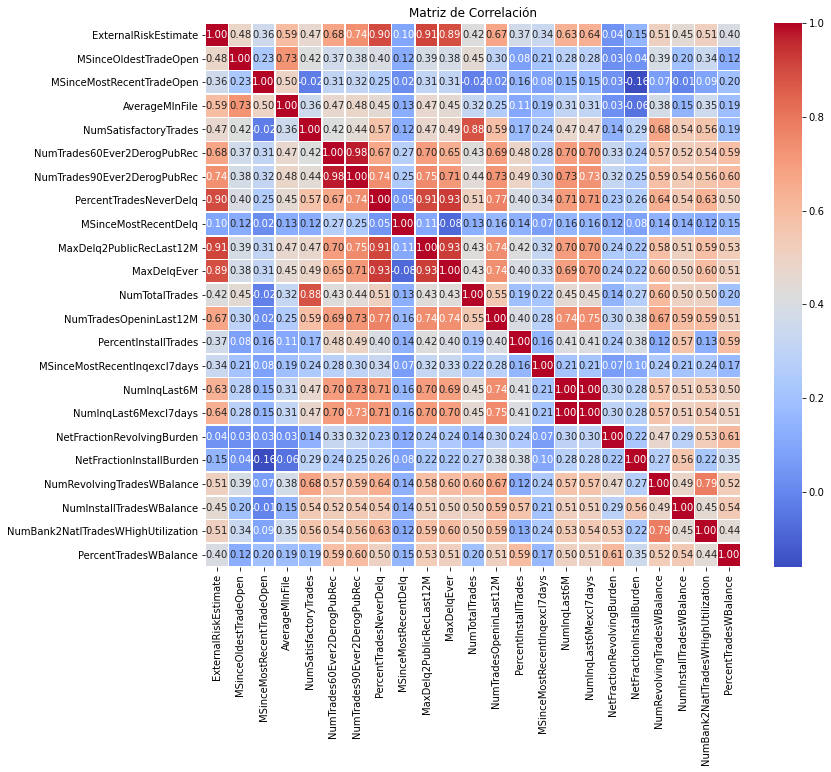

In [7]:


# Crear un mapa de calor para la matriz de correlación
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de Correlación')
plt.show()

In [8]:
# Observar la distribución de las variables
hist = ClassHistogram().explain_data(X_train, y_train, name='Train Data')
show(hist)

<!-- http://127.0.0.1:7368/1829489097840/ -->

# Árboles de decisión

Para esta primera parte crearemos árboles con los hiperparámetros por defecto de las librerías

In [42]:
# Entrenar modelo
tree = ClassificationTree()
tree.fit(X_train, y_train)

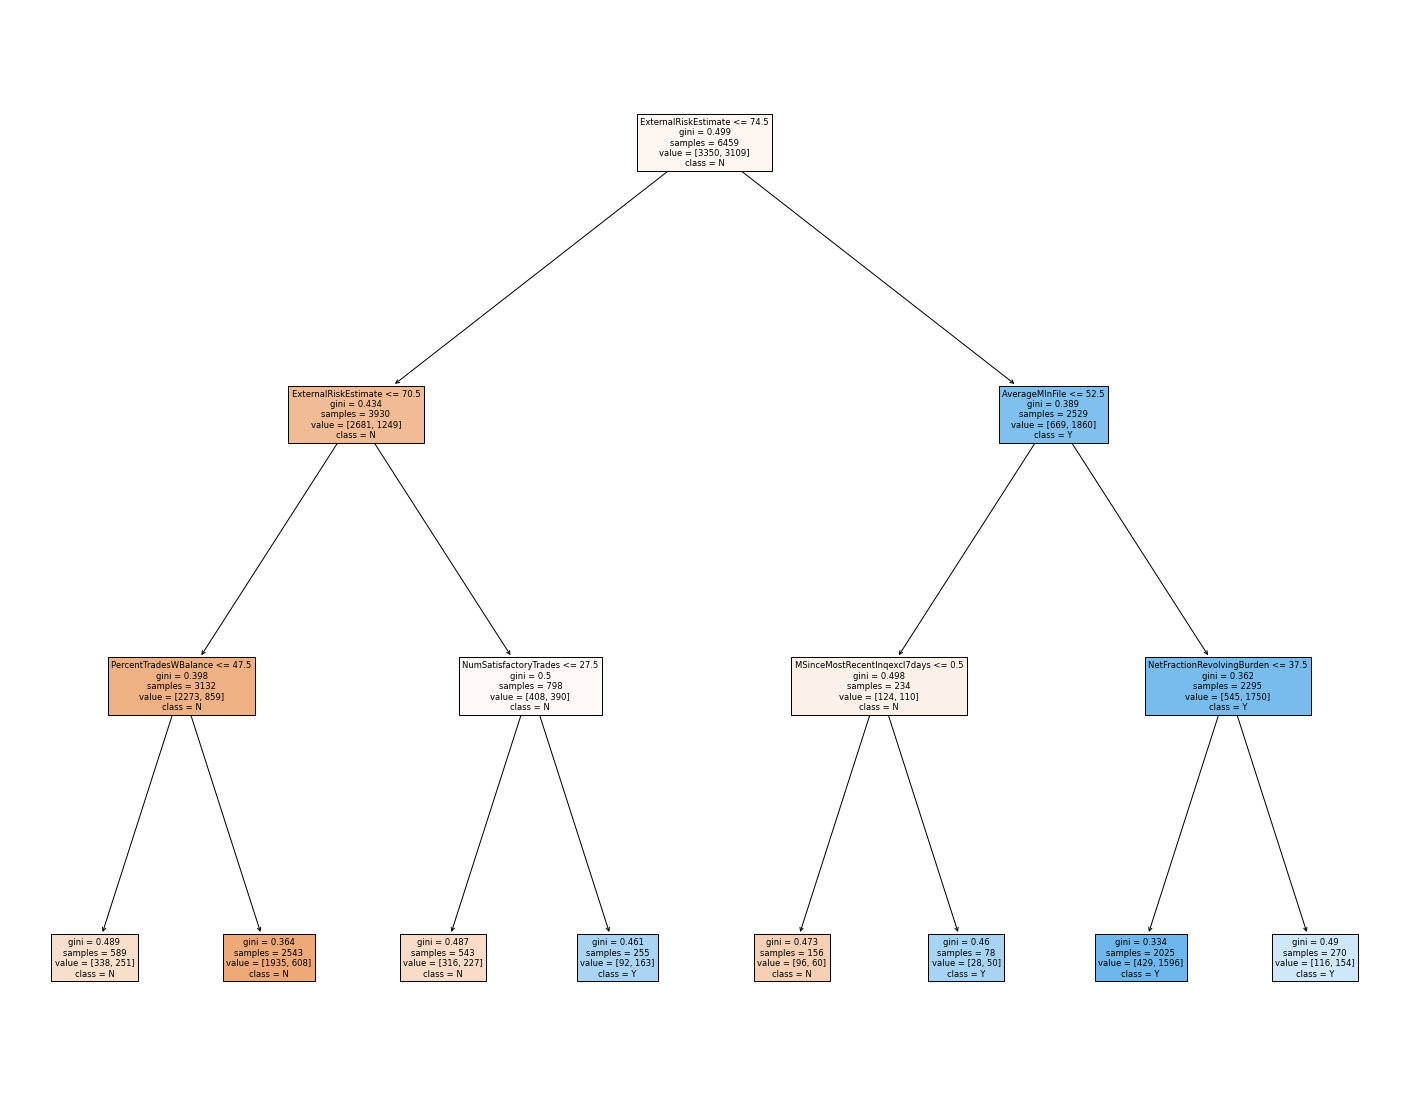

In [43]:
fig = plt.figure(figsize=(25,20))
_ = plot_tree(tree._model(),
                   feature_names=feature_cols,
                   class_names=['N', 'Y'],
                   filled=True)

In [44]:
# Para interpretación global
tree_global = tree.explain_global()
show(tree_global)

<!-- http://127.0.0.1:7368/1829569758784/ -->

In [45]:
# Crear un nuevo árbol de clasificación con un límite en el número máximo de individuos por hoja
tree_with_leaf_limit = ClassificationTree(min_samples_leaf=100, max_depth=None)
tree_with_leaf_limit.fit(X_train, y_train)

# Explicar el árbol globalmente
tree_global_with_leaf_limit = tree_with_leaf_limit.explain_global()
show(tree_global_with_leaf_limit)

<!-- http://127.0.0.1:7368/1829578496464/ -->

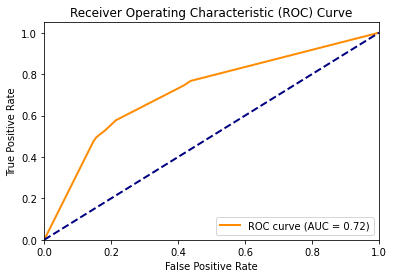

In [48]:
# Compute ROC curve and ROC area for each class
roc_auc = roc_auc_score(y_validation.map({'Bad': 0, 'Good': 1}), tree.predict_proba(X_validation)[:, 1])
fpr, tpr, _ = roc_curve(y_validation.map({'Bad': 0, 'Good': 1}), tree.predict_proba(X_validation)[:, 1])

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [15]:
print(f"DT AUC: {roc_auc_score(y_validation, tree.predict_proba(X_validation)[:,1]):.2f}")

DT AUC: 0.72


In [20]:
y_pred = tree.predict(X_validation)

report = classification_report(y_validation, y_pred)
print(report)

              precision    recall  f1-score   support

         Bad       0.67      0.79      0.72      1033
        Good       0.72      0.58      0.64       967

    accuracy                           0.69      2000
   macro avg       0.69      0.68      0.68      2000
weighted avg       0.69      0.69      0.68      2000



In [21]:
# Ejemplos para interpretación local
tree_local = tree.explain_local(X_test[:10], y_test[:10], name='EBM')
show(tree_local)

<!-- http://127.0.0.1:7368/1829569469792/ -->

## Búsqueda de hiperparámetros

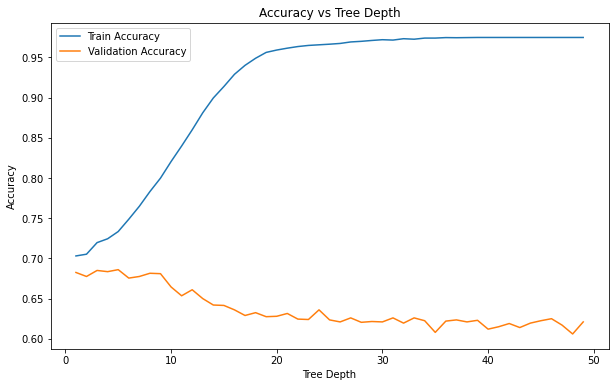

In [22]:
# Prueba de distintos valores de profundidad
depths = range(1, 50)
train_accuracies = []
validation_accuracies = []

for depth in depths:
    tree = ClassificationTree(max_depth=depth)
    tree.fit(X_train, y_train)
    train_accuracies.append(tree.score(X_train, y_train))
    validation_accuracies.append(tree.score(X_validation, y_validation))

plt.figure(figsize=(10, 6))
plt.plot(depths, train_accuracies, label='Train Accuracy')
plt.plot(depths, validation_accuracies, label='Validation Accuracy')
plt.xlabel('Tree Depth')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Tree Depth')
plt.legend()
plt.show()

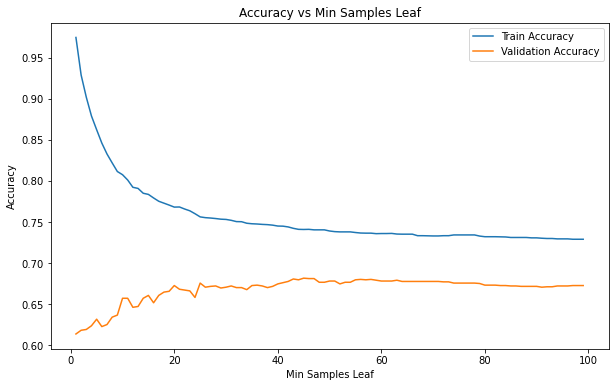

In [23]:
# Prueba de distintos valores de min_samples_leaf
min_samples_leaf_values = range(1, 100)
train_accuracies_leaf = []
validation_accuracies_leaf = []

for min_samples_leaf in min_samples_leaf_values:
    tree = ClassificationTree(min_samples_leaf=min_samples_leaf, max_depth=None)
    tree.fit(X_train, y_train)
    train_accuracies_leaf.append(tree.score(X_train, y_train))
    validation_accuracies_leaf.append(tree.score(X_validation, y_validation))

plt.figure(figsize=(10, 6))
plt.plot(min_samples_leaf_values, train_accuracies_leaf, label='Train Accuracy')
plt.plot(min_samples_leaf_values, validation_accuracies_leaf, label='Validation Accuracy')
plt.xlabel('Min Samples Leaf')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Min Samples Leaf')
plt.legend()
plt.show()

In [24]:
# Test the absolute best combination of depth and min_samples_leaf
depths = range(1, 10)
min_samples_leaf_values = range(10, 50, 5)

best_depth = None
best_min_samples_leaf = None
best_accuracy = 0

for depth in depths:
    for min_samples_leaf in min_samples_leaf_values:
        tree = ClassificationTree(max_depth=depth, min_samples_leaf=min_samples_leaf)
        tree.fit(X_train, y_train)
        accuracy = tree.score(X_validation, y_validation)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_depth = depth
            best_min_samples_leaf = min_samples_leaf

print(f"Best Depth: {best_depth}")
print(f"Best Min Samples Leaf: {best_min_samples_leaf}")
print(f"Best Accuracy: {best_accuracy:.2f}")

Best Depth: 5
Best Min Samples Leaf: 20
Best Accuracy: 0.69


## Modelo final e interpretabilidad

### Interpretabilidad global

In [25]:
# Crear un nuevo árbol de clasificación con un límite en el número máximo de individuos por hoja
tree_final = ClassificationTree(min_samples_leaf=100, max_depth=5)
tree_final.fit(X_train, y_train)

# Explicar el árbol globalmente
tree_final_global = tree_final.explain_global()
show(tree_final_global)

<!-- http://127.0.0.1:7368/1829529716864/ -->

In [26]:
tree_final._model().feature_importances_

array([0.77320669, 0.0314845 , 0.        , 0.05710476, 0.02953904,
       0.        , 0.        , 0.02236453, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.01291708, 0.        ,
       0.        , 0.        , 0.03174181, 0.        , 0.        ,
       0.        , 0.        , 0.04164159])

### Métricas

In [35]:
y_pred_train = tree_final.predict(X_train)
y_pred = tree_final.predict(X_test)

print(f"Accuracy train: {accuracy_score(y_train, y_pred_train):.4f}")
print(f"Accuracy test: {accuracy_score(y_test, y_pred):.4f}")
report = classification_report(y_test, y_pred)
print(report)

Accuracy train: 0.7240
Accuracy test: 0.7225
              precision    recall  f1-score   support

         Bad       0.73      0.77      0.75      1015
        Good       0.71      0.67      0.69       873

    accuracy                           0.72      1888
   macro avg       0.72      0.72      0.72      1888
weighted avg       0.72      0.72      0.72      1888



In [36]:
print(f"DT AUC: {roc_auc_score(y_test, tree_final.predict_proba(X_test)[:,1]):.4f}")

DT AUC: 0.7751


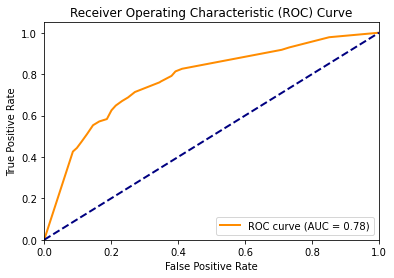

In [37]:
# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test.map({'Bad': 0, 'Good': 1}), tree_final.predict_proba(X_test)[:, 1])
roc_auc = roc_auc_score(y_test.map({'Bad': 0, 'Good': 1}), tree_final.predict_proba(X_test)[:, 1])
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### Interpretación local

In [38]:
# Ejemplos para interpretación local
tree_local = tree_final.explain_local(X_test[:20], y_test[:20], name='EBM')
show(tree_local)

<!-- http://127.0.0.1:7368/1829533754992/ -->

## Trasformación a reglas

In [39]:
print(export_text(tree_final._model(), feature_names=feature_cols))

|--- ExternalRiskEstimate <= 74.50
|   |--- ExternalRiskEstimate <= 70.50
|   |   |--- PercentTradesWBalance <= 47.50
|   |   |   |--- NetFractionRevolvingBurden <= 20.50
|   |   |   |   |--- PercentTradesNeverDelq <= 73.00
|   |   |   |   |   |--- class: Bad
|   |   |   |   |--- PercentTradesNeverDelq >  73.00
|   |   |   |   |   |--- class: Good
|   |   |   |--- NetFractionRevolvingBurden >  20.50
|   |   |   |   |--- class: Bad
|   |   |--- PercentTradesWBalance >  47.50
|   |   |   |--- MSinceOldestTradeOpen <= 146.50
|   |   |   |   |--- ExternalRiskEstimate <= 63.50
|   |   |   |   |   |--- class: Bad
|   |   |   |   |--- ExternalRiskEstimate >  63.50
|   |   |   |   |   |--- class: Bad
|   |   |   |--- MSinceOldestTradeOpen >  146.50
|   |   |   |   |--- ExternalRiskEstimate <= 67.50
|   |   |   |   |   |--- class: Bad
|   |   |   |   |--- ExternalRiskEstimate >  67.50
|   |   |   |   |   |--- class: Bad
|   |--- ExternalRiskEstimate >  70.50
|   |   |--- NumSatisfactoryTrades <

In [40]:
def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []

    def recurse(node, path, paths):

        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 3)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 3)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]

    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]

    rules = []
    for path in paths:
        rule = "if "

        for p in path[:-1]:
            if rule != "if ":
                rule += " and "
            rule += str(p)
        rule += " then "
        if class_names is None:
            rule += "response: "+str(np.round(path[-1][0][0][0],3))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),2)}%)"
        rule += f" | based on {path[-1][1]:,} samples"
        rules += [rule]

    return rules

In [41]:
rules = get_rules(tree_final._model(), feature_cols, ['N','Y'])
for r in rules:
    print(r)

if (ExternalRiskEstimate > 74.5) and (AverageMInFile > 52.5) and (NetFractionRevolvingBurden <= 37.5) and (PercentTradesNeverDelq > 94.5) and (NumSatisfactoryTrades > 9.5) then class: Y (proba: 82.73%) | based on 1,558 samples
if (ExternalRiskEstimate <= 74.5) and (ExternalRiskEstimate <= 70.5) and (PercentTradesWBalance > 47.5) and (MSinceOldestTradeOpen > 146.5) and (ExternalRiskEstimate <= 67.5) then class: N (proba: 74.54%) | based on 1,131 samples
if (ExternalRiskEstimate <= 74.5) and (ExternalRiskEstimate <= 70.5) and (PercentTradesWBalance > 47.5) and (MSinceOldestTradeOpen <= 146.5) and (ExternalRiskEstimate > 63.5) then class: N (proba: 79.57%) | based on 563 samples
if (ExternalRiskEstimate <= 74.5) and (ExternalRiskEstimate <= 70.5) and (PercentTradesWBalance > 47.5) and (MSinceOldestTradeOpen <= 146.5) and (ExternalRiskEstimate <= 63.5) then class: N (proba: 88.55%) | based on 524 samples
if (ExternalRiskEstimate <= 74.5) and (ExternalRiskEstimate <= 70.5) and (PercentTrade